<a href="https://colab.research.google.com/github/theclosedbook/TensorFlow/blob/main/05_Transfer_Learning_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning
In Previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: Fine-Tuning

In [ ]:
!nvidia-smi

Mon Feb 26 19:38:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Creating Helper functions

In previous notebooks, we've created a bunch of helper functions.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere).



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-26 19:38:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-26 19:38:40 (19.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

### Let's Get some data

This time we're going to see how we can use the pretrained models within `tf.keras.application` and apply
them to our own problems (recognizing images of food)

In [ ]:
# Get 10% of the training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-26 19:38:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   167MB/s    in 1.0s    

2024-02-26 19:38:50 (167 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirecteries are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[ 36.632652    27.632652    18.632652  ]
   [ 40.83163     31.83163     22.83163   ]
   [ 48.066326    39.066326    30.066326  ]
   ...
   [244.47954    214.90807    176.6938    ]
   [240.40306    210.40306    172.40306   ]
   [238.15811    208.15811    170.15811   ]]

  [[ 57.790817    53.576534    44.647964  ]
   [ 38.132652    31.331627    23.2653    ]
   [ 44.92347     37.92347     27.923468  ]
   ...
   [246.47453    216.47453    178.47453   ]
   [244.35709    214.35709    176.35709   ]
   [231.95392    201.95392    163.95392   ]]

  [[ 53.515305    50.515305    41.515305  ]
   [126.47961    123.47961    114.4796    ]
   [ 41.7653      37.93367     28.93367   ]
   ...
   [234.93878    204.51021    166.29593   ]
   [236.81123    204.81123    166.59694   ]
   [239.55617    207.55617    169.34189   ]]

  ...

  [[ 25.158075    19.729548    13.301019  ]
   [ 22.428549    17.000021    10.571493  ]
   [ 22.642792    17.214264    10.785736  ]
   ...
   [ 97.693375    70.907

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straigh forward, it runs our layers in sequential oreder


In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240226-193903
Epoch 1/5
24/24 [==============================] - 21s 378ms/step - loss: 1.8624 - accuracy: 0.4507 - val_loss: 1.3034 - val_accuracy: 0.7155
Epoch 2/5
24/24 [==============================] - 5s 171ms/step - loss: 1.1406 - accuracy: 0.7440 - val_loss: 0.9019 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 4s 132ms/step - loss: 0.8434 - accuracy: 0.8160 - val_loss: 0.7259 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 5s 181ms/step - loss: 0.6819 - accuracy: 0.8573 - val_loss: 0.6382 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 4s 133ms/step - loss: 0.5958 - accuracy: 0.8720 - val_loss: 0.5873 - val_accuracy: 0.8618


In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 87ms/step - loss: 0.5646 - accuracy: 0.8628


[0.5646107196807861, 0.8628000020980835]

In [ ]:
# check the layers in our base model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
# Summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
# Whole model summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

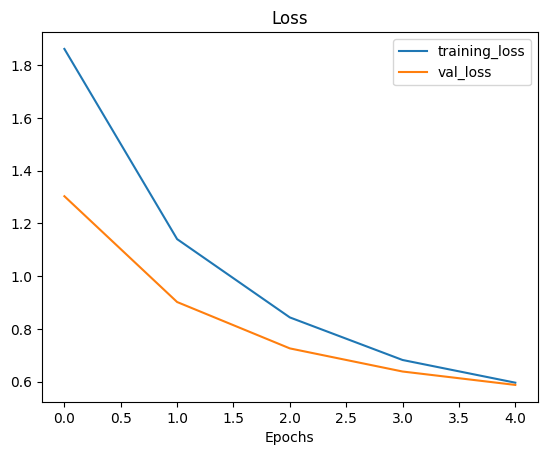

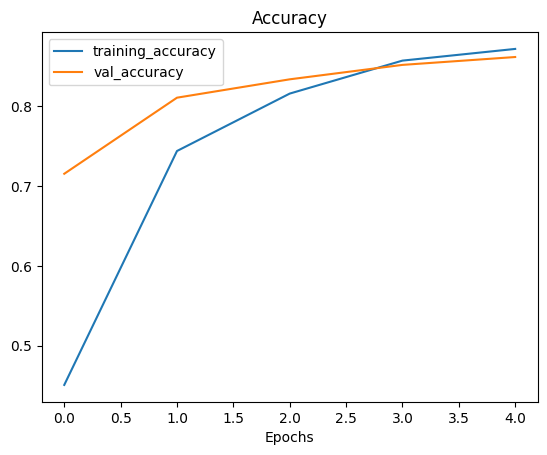

In [ ]:
# Check out our models training curves
plot_loss_curves(history_10_percent)

##Getting a feature vector from a trained model

Let's Demonstrate the Global Average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).

Let;s use similar shaped tenspr of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [ ]:
# Define Input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"SHape of Global Average Pooled 2D tensor :{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
SHape of Global Average Pooled 2D tensor :(1, 3)


In [ ]:
 # Lets replicate the GlobalAveragePool2D Layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10 of the training data, but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augumentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augumentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmenattion



## Getting and preprocessing data for model_1

In [ ]:
# Downlaod and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2024-02-26 19:39:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   139MB/s    in 0.9s    

2024-02-26 19:39:58 (139 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images we're working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [ ]:
# set up data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

benifits of using data augmentation inside the mmodel are:

* Perprocessing of images (augmenting them ) happens on the GPU (much faster) rather than CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations,zooms, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255) # models like ResNet50V2 need Rescale but EfficientNet's have rescaling builtin
],name ="data_augmentation")

### Visualise our data augmentation layer

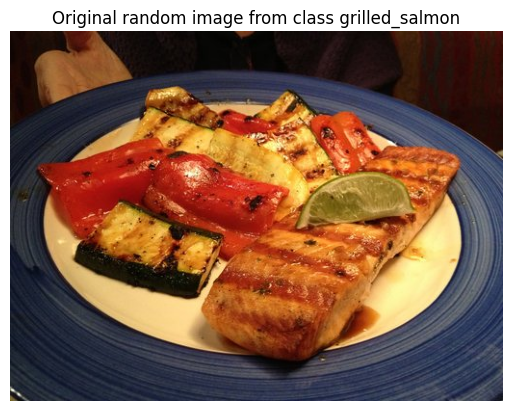

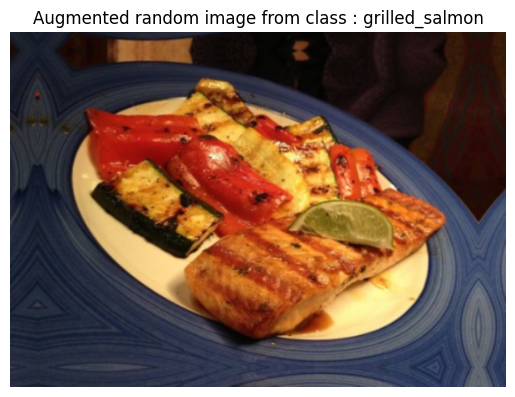

In [ ]:
# Viwe a random image and compare it to augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mping.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now lets plot augmented image
augmented_img = data_augmentation(tf.expand_dims(img , axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented random image from class : {target_class}")
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup the base model and input shape , freezing the base model layers
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x,training=False)

# Pool output features of teh base
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make amodel using the inouts and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25* len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data")])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data/20240226-194005
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.4962 - accuracy: 0.0571 - val_loss: 2.2117 - val_accuracy: 0.1711
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1618 - accuracy: 0.2571 - val_loss: 2.0786 - val_accuracy: 0.2697
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.9760 - accuracy: 0.3714 - val_loss: 1.9483 - val_accuracy: 0.3980
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.7835 - accuracy: 0.5571 - val_loss: 1.8593 - val_accuracy: 0.4819
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6484 - accuracy: 0.5714 - val_loss: 1.7553 - val_accuracy: 0.5559


In [ ]:
# model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 84ms/step - loss: 1.7667 - accuracy: 0.5268


[1.7666789293289185, 0.5267999768257141]

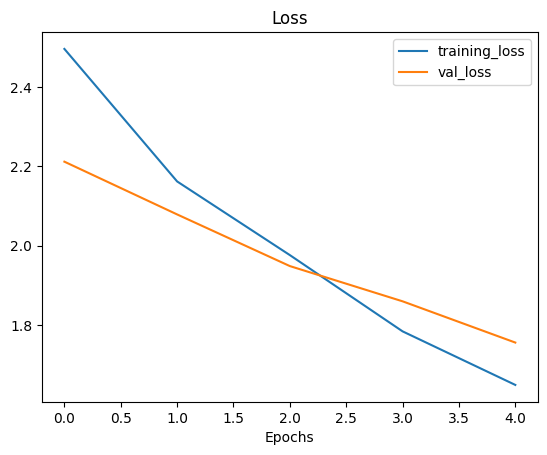

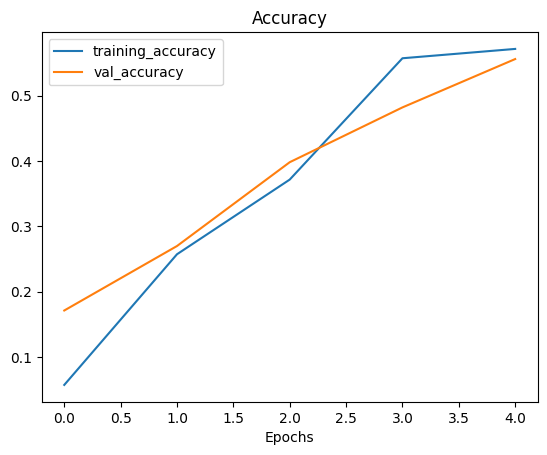

In [ ]:
plot_loss_curves(history_1_percent)

## Model 2 with 10% of the training data and adding data augmentation as layer

In [ ]:
# get 10% of the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-26 19:40:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  78.8MB/s    in 2.0s    

2024-02-26 19:40:56 (78.8 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# set up data loaders
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# create model 2 with data augmentation built in

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255) # models like ResNet50V2 need Rescale but EfficientNet's have rescaling builtin
],name ="data_augmentation")

# setup input shape t our model

input_shape = (224,224,3)

# create a frozen base model (also called as the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainble = False

# Create the inputs and outputs (includeing the layers in between)
inputs = layers.Input(shape=input_shape,name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentstion dosen't occur on test data)
x = base_model(x,training = False) # pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10,activation = "softmax" , name="output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


### Creating a model checkpoint callbacks

The ModelCheckpoint callback intermediatley saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "10_precent_model_checkpoints_weights/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callbacl = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints

initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name ="transfer_learning",
                                                                 experiment_name = "10_percent_data_aug"),
                                     checkpoint_callbacl])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240226-201424
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9902 - accuracy: 0.2920
Epoch 1: saving model to 10_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 107s 3s/step - loss: 1.9902 - accuracy: 0.2920 - val_loss: 1.6973 - val_accuracy: 0.4868
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2917 - accuracy: 0.5840
Epoch 2: saving model to 10_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 50s 2s/step - loss: 1.2917 - accuracy: 0.5840 - val_loss: 1.1114 - val_accuracy: 0.6250
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.7253
Epoch 3: saving model to 10_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 54s 2s/step - loss: 0.8500 - accuracy: 0.7253 - val_loss: 0.7433 - val_accuracy: 0.7533
Epoch 4/5
24

In [ ]:
results_10_per_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.9763 - accuracy: 0.7024


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 8s 66ms/step - loss: 0.5646 - accuracy: 0.8628


[0.5646107196807861, 0.8628000020980835]

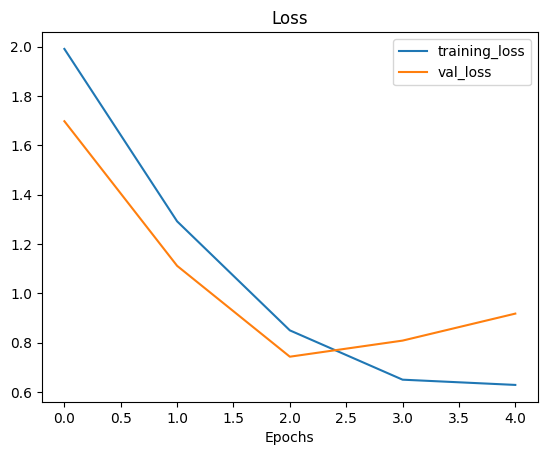

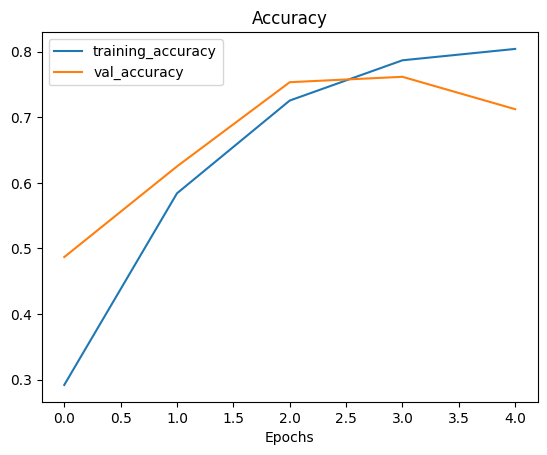

In [ ]:
# plot model loss curves
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpoints weights returns a model to a specefic checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weigths
loaded_weights_model_results = model_2.evaluate(test_data)


79/79 [==============================] - 7s 85ms/step - loss: 0.9763 - accuracy: 0.7024


In [ ]:
# If the results from our previosuly evaluated model_2 match the loaded weights, everyrhing has worked!
results_10_per_data_aug == loaded_weights_model_results

False

In [43]:
results_10_per_data_aug

[0.9762762784957886, 0.7024000287055969]

In [44]:
loaded_weights_model_results

[0.9762760996818542, 0.7024000287055969]

In [45]:
# Check to see if loade model results are very close
import numpy as np
np.isclose(np.array(results_10_per_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])